# Chennai House Price Prediction

Chennai is considered to be one of the most expensive places to live in India. The price of property is majorly dependant on few factors such as
* Popularity of the area
* Distance form the nearest main road or highway
* Number of schools, hospitals and other amenities in the close vicinity
* Road conditions
* Type of property sold (Commercial places are priced more than houses)

This project involves the prediction of prices at various locations of most popular neighborhoods of chennai namely
1. Anna Nagar
2. Adyar
3. Karapakkam
4. Velachery
5. T Nagar
6. KK Nagar
7. Chrompet

The data obtained from Kaggle is leveraged in order to predict the price of the property. The Foursquare API is used in order to find the closest hospitals and schools to the particular neighborhood 

In [1]:
import pandas as pd
import numpy as np
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.tree import DecisionTreeClassifier

In [2]:
df_price=pd.read_csv('train.csv')

In [3]:
df_price.head()

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,...,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,...,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,...,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200
3,P05346,Velachery,1855,13-03-2010,14,3.0,2.0,5,Family,No,...,NoSewr,Paved,I,4.7,3.9,3.6,4.010,356321,77042,9630290
4,P06210,Karapakkam,1226,05-10-2009,84,1.0,1.0,3,AbNormal,Yes,...,AllPub,Gravel,C,3.0,2.5,4.1,3.290,237000,74063,7406250


In [4]:
df_price[['QS_ROOMS','SALES_PRICE']].corr()

,QS_ROOMS,SALES_PRICE
QS_ROOMS,1.000000,0.021967
SALES_PRICE,0.021967,1.000000


The unnecessary columns that do not contribute to the analysis are removed

In [5]:
unwanted_col=['PRT_ID','DATE_SALE','UTILITY_AVAIL','MZZONE','QS_ROOMS','QS_BATHROOM','QS_BEDROOM','QS_OVERALL','DATE_BUILD']
df_price.drop(unwanted_col,axis=1,inplace=True)

In [6]:
df_price.head()

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,STREET,REG_FEE,COMMIS,SALES_PRICE
0,Karapakkam,1004,131,1.0,1.0,3,AbNormal,Yes,Commercial,Paved,380000,144400,7600000
1,Anna Nagar,1986,26,2.0,1.0,5,AbNormal,No,Commercial,Gravel,760122,304049,21717770
2,Adyar,909,70,1.0,1.0,3,AbNormal,Yes,Commercial,Gravel,421094,92114,13159200
3,Velachery,1855,14,3.0,2.0,5,Family,No,Others,Paved,356321,77042,9630290
4,Karapakkam,1226,84,1.0,1.0,3,AbNormal,Yes,Others,Gravel,237000,74063,7406250


### In order to simplify the analysis process instead of predicting the property price it is quite simpler to predict the price per square feet, thereby reducing various dimensions from the dataframe
* Property measurement
* Number of bedrooms
* Number of bathrooms
* Number of rooms

In [7]:
df_price['Price_per_sqft']=(df_price['REG_FEE']+df_price['COMMIS']+df_price['SALES_PRICE'])/df_price['INT_SQFT']

In [8]:
df_price.head()

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,STREET,REG_FEE,COMMIS,SALES_PRICE,Price_per_sqft
0,Karapakkam,1004,131,1.0,1.0,3,AbNormal,Yes,Commercial,Paved,380000,144400,7600000,8092.031873
1,Anna Nagar,1986,26,2.0,1.0,5,AbNormal,No,Commercial,Gravel,760122,304049,21717770,11471.269386
2,Adyar,909,70,1.0,1.0,3,AbNormal,Yes,Commercial,Gravel,421094,92114,13159200,15041.152915
3,Velachery,1855,14,3.0,2.0,5,Family,No,Others,Paved,356321,77042,9630290,5425.149865
4,Karapakkam,1226,84,1.0,1.0,3,AbNormal,Yes,Others,Gravel,237000,74063,7406250,6294.708809


In [9]:
df_price.drop(['INT_SQFT','REG_FEE','COMMIS','SALES_PRICE'],axis=1,inplace=True)

In [10]:
df_price.head()

,AREA,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,STREET,Price_per_sqft
0,Karapakkam,131,1.0,1.0,3,AbNormal,Yes,Commercial,Paved,8092.031873
1,Anna Nagar,26,2.0,1.0,5,AbNormal,No,Commercial,Gravel,11471.269386
2,Adyar,70,1.0,1.0,3,AbNormal,Yes,Commercial,Gravel,15041.152915
3,Velachery,14,3.0,2.0,5,Family,No,Others,Paved,5425.149865
4,Karapakkam,84,1.0,1.0,3,AbNormal,Yes,Others,Gravel,6294.708809


The data is cleaned with atmost care

In [11]:
df_price['SALE_COND'].unique()

array(['AbNormal', 'Family', 'Partial', 'AdjLand', 'Normal Sale',
       'Ab Normal', 'Partiall', 'Adj Land', 'PartiaLl'], dtype=object)

In [12]:
df_price['SALE_COND'].replace('Ab Normal','AbNormal',inplace=True)

In [13]:
df_price['SALE_COND'].replace('PartiaLl','Partial',inplace=True)

In [14]:
df_price['SALE_COND'].replace('Partiall','Partial',inplace=True)

In [15]:
df_price['SALE_COND'].replace('Adj Land','AdjLand',inplace=True)

In [16]:
df_price['SALE_COND'].unique()

array(['AbNormal', 'Family', 'Partial', 'AdjLand', 'Normal Sale'],
      dtype=object)

In [17]:
df_price.drop(['N_BEDROOM','N_BATHROOM','N_ROOM'],axis=1,inplace=True)

In [18]:
df_price.head()

,AREA,DIST_MAINROAD,SALE_COND,PARK_FACIL,BUILDTYPE,STREET,Price_per_sqft
0,Karapakkam,131,AbNormal,Yes,Commercial,Paved,8092.031873
1,Anna Nagar,26,AbNormal,No,Commercial,Gravel,11471.269386
2,Adyar,70,AbNormal,Yes,Commercial,Gravel,15041.152915
3,Velachery,14,Family,No,Others,Paved,5425.149865
4,Karapakkam,84,AbNormal,Yes,Others,Gravel,6294.708809


In [19]:
df_price['BUILDTYPE'].unique()

array(['Commercial', 'Others', 'Other', 'House', 'Comercial'],
      dtype=object)

In [20]:
df_price['BUILDTYPE'].replace('Comercial','Commercial',inplace=True)

In [21]:
df_price['BUILDTYPE'].replace('Other','Others',inplace=True)

In [22]:
df_price['BUILDTYPE'].unique()

array(['Commercial', 'Others', 'House'], dtype=object)

In [23]:
df_price['STREET'].unique()

array(['Paved', 'Gravel', 'No Access', 'Pavd', 'NoAccess'], dtype=object)

In [24]:
df_price['STREET'].replace('NoAccess','No Access',inplace=True)

In [25]:
df_price['STREET'].replace('Pavd','Paved',inplace=True)

In [26]:
df_price['STREET'].unique()

array(['Paved', 'Gravel', 'No Access'], dtype=object)

In [27]:
df_price['PARK_FACIL'].unique()

array(['Yes', 'No', 'Noo'], dtype=object)

In [28]:
df_price['PARK_FACIL'].replace('Noo','No',inplace=True)

In [29]:
df_price.head()

,AREA,DIST_MAINROAD,SALE_COND,PARK_FACIL,BUILDTYPE,STREET,Price_per_sqft
0,Karapakkam,131,AbNormal,Yes,Commercial,Paved,8092.031873
1,Anna Nagar,26,AbNormal,No,Commercial,Gravel,11471.269386
2,Adyar,70,AbNormal,Yes,Commercial,Gravel,15041.152915
3,Velachery,14,Family,No,Others,Paved,5425.149865
4,Karapakkam,84,AbNormal,Yes,Others,Gravel,6294.708809


In [30]:
df_price['AREA'].unique()

array(['Karapakkam', 'Anna Nagar', 'Adyar', 'Velachery', 'Chrompet',
       'KK Nagar', 'TNagar', 'T Nagar', 'Chrompt', 'Chrmpet', 'Karapakam',
       'Ana Nagar', 'Chormpet', 'Adyr', 'Velchery', 'Ann Nagar',
       'KKNagar'], dtype=object)

In [31]:
df_price['AREA'].replace('Adyr','Adyar',inplace=True)
df_price['AREA'].replace('TNagar','T Nagar',inplace=True)
df_price['AREA'].replace('Chrmpet','Chrompet',inplace=True)
df_price['AREA'].replace('Chormpet','Chrompet',inplace=True)
df_price['AREA'].replace('Chrompt','Chrompet',inplace=True)
df_price['AREA'].replace('Karapakam','Karapakkam',inplace=True)
df_price['AREA'].replace('Ann Nagar','Anna Nagar',inplace=True)
df_price['AREA'].replace('Velchery','Velachery',inplace=True)
df_price['AREA'].replace('KKNagar','KK Nagar',inplace=True)
df_price['AREA'].replace('Ana Nagar','Anna Nagar',inplace=True)

In [32]:
df_price['AREA'].unique()

array(['Karapakkam', 'Anna Nagar', 'Adyar', 'Velachery', 'Chrompet',
       'KK Nagar', 'T Nagar'], dtype=object)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
neigh_list=list(df_price['AREA'].unique())

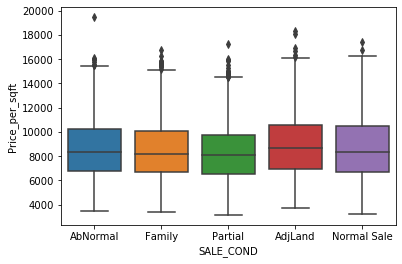

In [34]:
sns.boxplot(x='SALE_COND',y='Price_per_sqft',data=df_price)

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


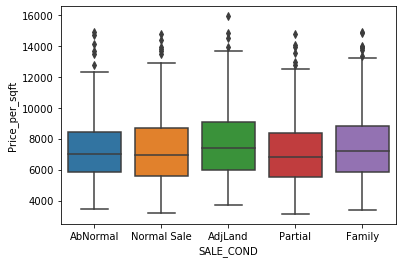

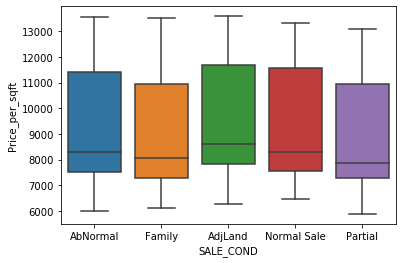

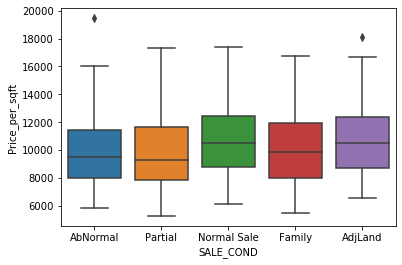

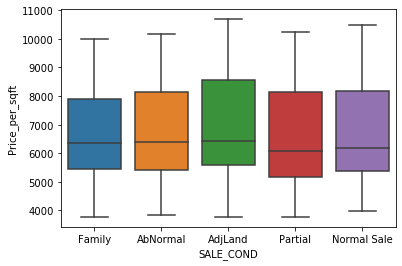

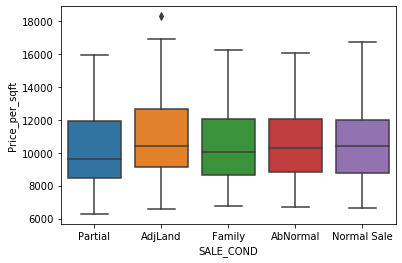

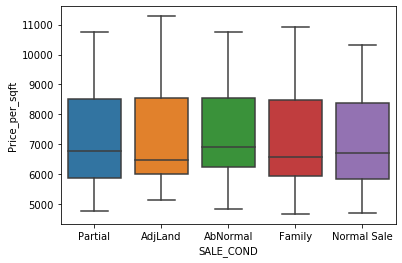

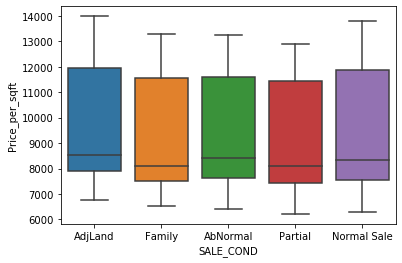

In [35]:
for i in neigh_list:
    print(i)
    plt.figure(i)
    sns.boxplot(x='SALE_COND',y='Price_per_sqft',data=df_price[df_price['AREA']==i])

### Since the popularity of the area is one important factor it is essential to check its dependancy. From the above box plots for each area the overlap of category is significant and hence it has very minimum role to play in price predicition 

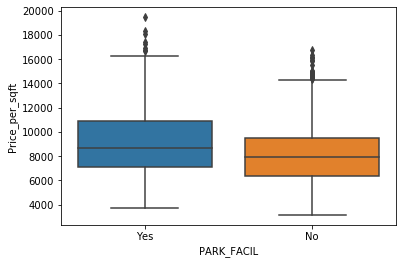

In [36]:
sns.boxplot(x='PARK_FACIL',y='Price_per_sqft',data=df_price)

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


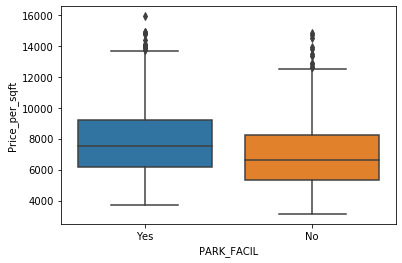

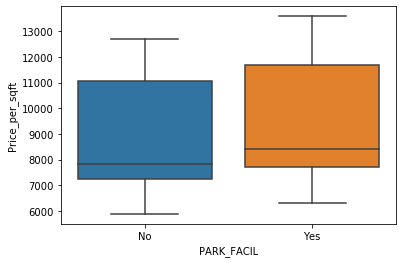

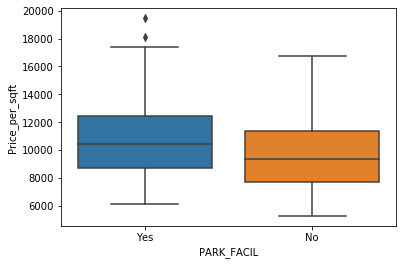

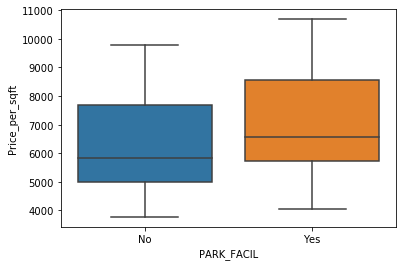

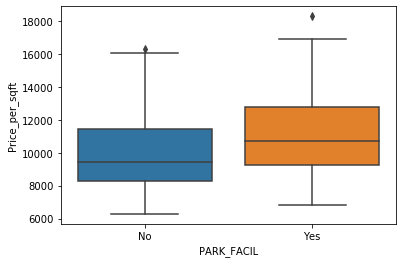

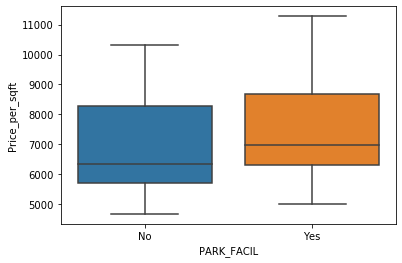

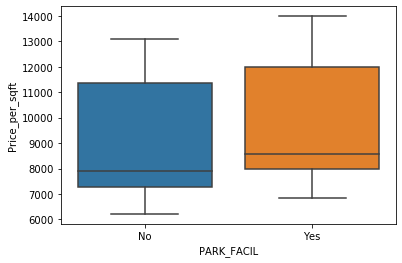

In [37]:
import seaborn as sns
for i in neigh_list:
    print(i)
    plt.figure(i)
    sns.boxplot(x='PARK_FACIL',y='Price_per_sqft',data=df_price[df_price['AREA']==i])

### Eventhough it does not show much variation to avoid underfitting park facility will be taken into consideration

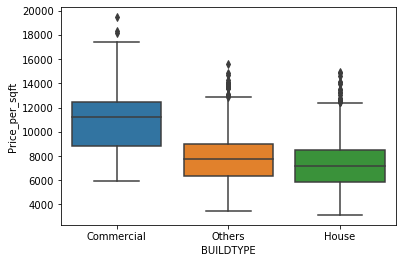

In [38]:
 sns.boxplot(x='BUILDTYPE',y='Price_per_sqft',data=df_price)

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


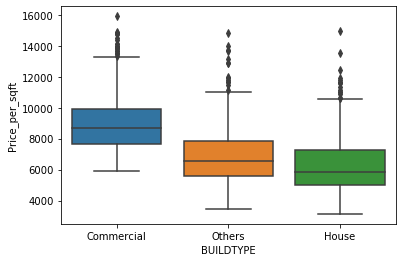

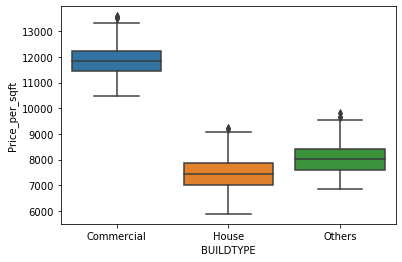

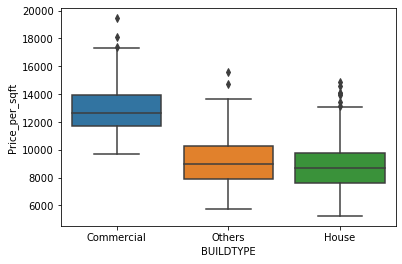

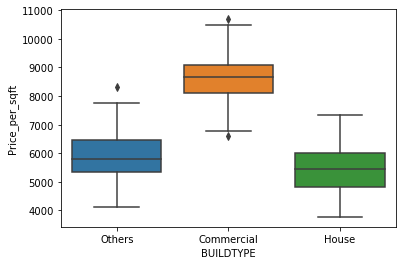

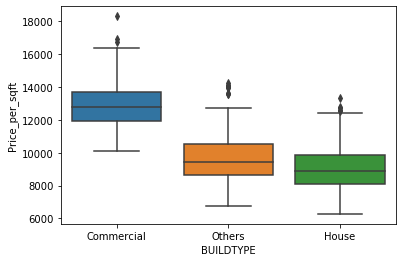

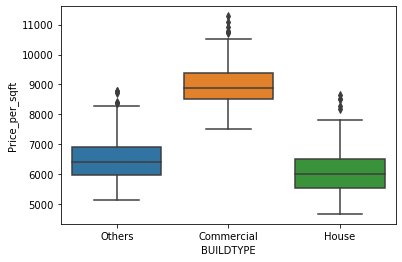

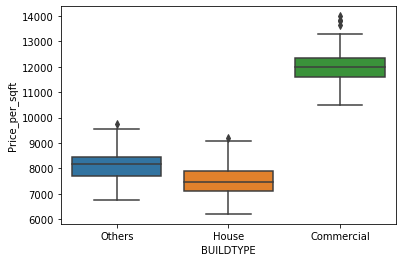

In [39]:
for i in neigh_list:
    print(i)
    plt.figure(i)
    sns.boxplot(x='BUILDTYPE',y='Price_per_sqft',data=df_price[df_price['AREA']==i])

 ### The category build type has proved to be a worthy predictor so taken into consideration

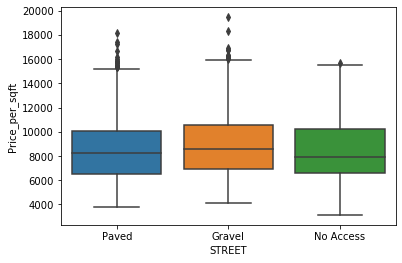

In [40]:
sns.boxplot(x='STREET',y='Price_per_sqft',data=df_price)

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


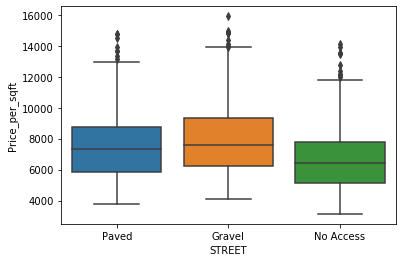

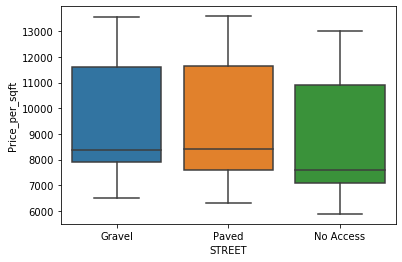

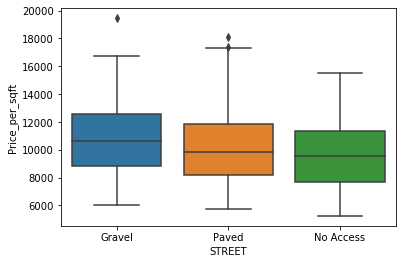

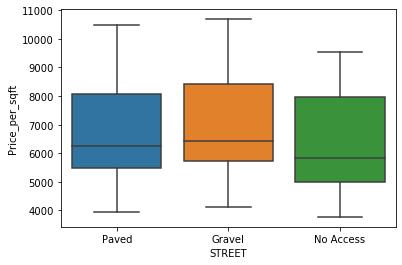

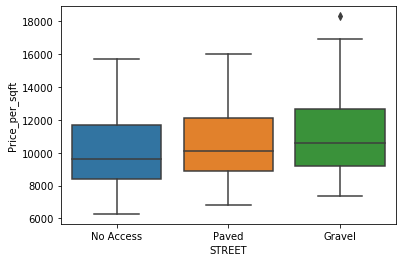

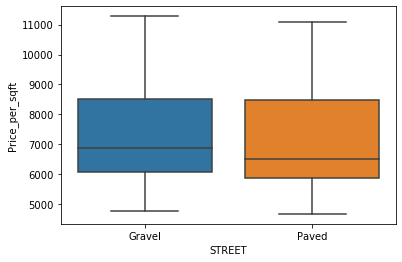

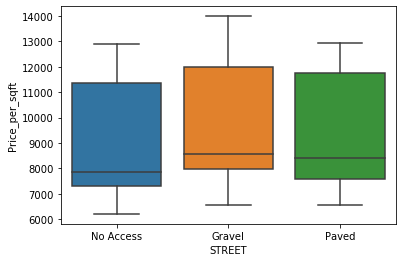

In [41]:
for i in neigh_list:
    print(i)
    plt.figure(i)
    sns.boxplot(x='STREET',y='Price_per_sqft',data=df_price[df_price['AREA']==i])

### Street category can be omited

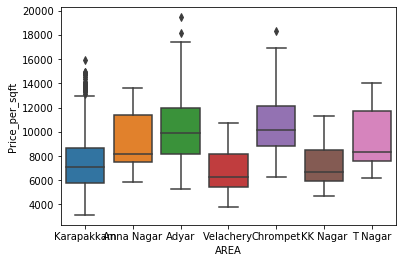

In [42]:
sns.boxplot(x='AREA',y='Price_per_sqft',data=df_price)

### The most important category the popularity of the area

The popular places of the locality are plotted on the map of chennai using geopy

In [43]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

#### The latitudes and the longitudes of the neighborhood are found using geolocator

In [44]:
lat=[]
long=[]
unique_places=[]
for i in (df_price['AREA'].unique()):
    try:
        address = i
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        long.append(longitude)
        unique_places.append(i)
        print(i)
    except:
        lat.append(np.nan)
        long.append(np.nan)
        print('lat long not available {}'.format(i))

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


In [45]:
df_cord=pd.DataFrame(unique_places,columns=['AREA'])

In [46]:
df_cord['Latitudes']=lat
df_cord['Longitudes']=long

In [47]:
df_cord

,AREA,Latitudes,Longitudes
0,Karapakkam,12.911707,80.227720
1,Anna Nagar,13.087200,80.216442
2,Adyar,13.006450,80.257779
3,Velachery,12.980165,80.222851
4,Chrompet,12.939421,80.136613
5,KK Nagar,13.038649,80.205216
6,T Nagar,13.029448,80.230906


In [48]:
df_price.shape

(7109, 7)

### Removing the unwanted columns from the df_price dataframe

In [49]:
df_price.drop(['SALE_COND','STREET'],axis=1,inplace=True)

In [50]:
df_price.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE,Price_per_sqft
0,Karapakkam,131,Yes,Commercial,8092.031873
1,Anna Nagar,26,No,Commercial,11471.269386
2,Adyar,70,Yes,Commercial,15041.152915
3,Velachery,14,No,Others,5425.149865
4,Karapakkam,84,Yes,Others,6294.708809


#### Merging the df_price and df_cord dataframe on AREA

In [51]:
df_merge_col = pd.merge(df_price, df_cord, on='AREA')

In [52]:
df_merge_col.shape

(7109, 7)

In [53]:
df_merge_col.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE,Price_per_sqft,Latitudes,Longitudes
0,Karapakkam,131,Yes,Commercial,8092.031873,12.911707,80.22772
1,Karapakkam,84,Yes,Others,6294.708809,12.911707,80.22772
2,Karapakkam,175,Yes,House,5503.082367,12.911707,80.22772
3,Karapakkam,59,Yes,Others,6432.255957,12.911707,80.22772
4,Karapakkam,180,No,House,4273.815661,12.911707,80.22772


In [54]:
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, neighborhood in zip(df_cord['Latitudes'], df_cord['Longitudes'], df_cord['AREA']):
    try:
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_chennai)
    except:
        pass
map_chennai

#### By leveraging the foursquare API data the hospitals and schools nearby are taken into consideration

In [93]:
CLIENT_ID = 'Your fou'
CLIENT_SECRET = 'LWTWBGEE2SKX3HIHXLX5SI4503FH3DSISEKTS0CDLCHZ5JC2'
VERSION = '20180605'

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):  
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        try:
            url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d13b941735,4bf58dd8d48988d196941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                100)
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
             venues_list.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [57]:
chennai_venues = getNearbyVenues(names=df_cord['AREA'],
                                   latitudes=df_cord['Latitudes'],
                                   longitudes=df_cord['Longitudes']
                                  )

Karapakkam
Anna Nagar
Adyar
Velachery
Chrompet
KK Nagar
T Nagar


In [58]:
chennai_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Karapakkam,12.911707,80.227720,Apollo Clinic,12.913181,80.229126,Hospital
1,Karapakkam,12.911707,80.227720,Chettinad Urban Health Centre,12.910563,80.230990,Hospital
2,Karapakkam,12.911707,80.227720,Apollo Cradle Maternity Hospital,12.914931,80.229585,Hospital
3,Anna Nagar,13.087200,80.216442,City Tower Hospital,13.084799,80.216116,Hospital
4,Anna Nagar,13.087200,80.216442,The Apollo Clinic,13.089032,80.218126,Hospital
5,Anna Nagar,13.087200,80.216442,Soundarapandian Bone And Joint Hospital,13.083893,80.215833,Hospital
6,Anna Nagar,13.087200,80.216442,Dr Agarwal's Eye Hospital,13.084106,80.217968,Hospital
7,Anna Nagar,13.087200,80.216442,Oliva Skin & Hair Clinic Anna Nagar,13.085080,80.212405,Hospital
8,Anna Nagar,13.087200,80.216442,Jai Gopal Garodia Vidyalaya School,13.089343,80.214250,High School
9,Adyar,13.006450,80.257779,SISHMUN,13.005223,80.257805,School


### This is an important step.
### Assigning weights to a locality based on number of hospitals and schools around
 * For each hospital in the locality a weight of 2 is added
 * For each school in the locality a weight of 1 is added

In [59]:
weight_venue=[]
for i in df_cord['AREA'].values.tolist():
    new_df=chennai_venues[chennai_venues['Neighborhood']==i]['Venue Category']
    new_list=new_df.values.tolist()
    skl='School'
    h_value=0
    s_value=0
    for i in new_list:
        if i=='Hospital':
            h_value+=2
        if skl in i:
            s_value+=1
        tot_weight=h_value+s_value
    weight_venue.append(tot_weight)
weight_venue

[6, 11, 7, 14, 14, 8, 8]

In [60]:
df_cord['venue weight']=weight_venue

In [61]:
df_cord.head()

,AREA,Latitudes,Longitudes,venue weight
0,Karapakkam,12.911707,80.227720,6
1,Anna Nagar,13.087200,80.216442,11
2,Adyar,13.006450,80.257779,7
3,Velachery,12.980165,80.222851,14
4,Chrompet,12.939421,80.136613,14


#### Merging the data frames df_merge_col and AREA and venue weight columns of df_cord on AREA column 

In [62]:
df_model= pd.merge(df_merge_col, df_cord[['AREA','venue weight']], on='AREA')

In [63]:
df_model.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE,Price_per_sqft,Latitudes,Longitudes,venue weight
0,Karapakkam,131,Yes,Commercial,8092.031873,12.911707,80.22772,6
1,Karapakkam,84,Yes,Others,6294.708809,12.911707,80.22772,6
2,Karapakkam,175,Yes,House,5503.082367,12.911707,80.22772,6
3,Karapakkam,59,Yes,Others,6432.255957,12.911707,80.22772,6
4,Karapakkam,180,No,House,4273.815661,12.911707,80.22772,6


In [64]:
df_model=df_model[['AREA','PARK_FACIL','BUILDTYPE','DIST_MAINROAD','venue weight','Price_per_sqft']]

In [65]:
df_model.head()

,AREA,PARK_FACIL,BUILDTYPE,DIST_MAINROAD,venue weight,Price_per_sqft
0,Karapakkam,Yes,Commercial,131,6,8092.031873
1,Karapakkam,Yes,Others,84,6,6294.708809
2,Karapakkam,Yes,House,175,6,5503.082367
3,Karapakkam,Yes,Others,59,6,6432.255957
4,Karapakkam,No,House,180,6,4273.815661


In [66]:
df_model.dtypes

AREA               object
PARK_FACIL         object
BUILDTYPE          object
DIST_MAINROAD       int64
venue weight        int64
Price_per_sqft    float64
dtype: object

In [67]:
X_train=df_model.iloc[:,0:5].values

In [68]:
Y_train=df_model.iloc[:,5].values

#### Encoding the categorical variable of the dataframe in order to build a numerical based model

In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,2])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
print(X_train)

[[0.0 0.0 0.0 ... 0.0 131 6]
 [0.0 0.0 0.0 ... 1.0 84 6]
 [0.0 0.0 0.0 ... 0.0 175 6]
 ...
 [0.0 0.0 0.0 ... 0.0 188 8]
 [0.0 0.0 0.0 ... 1.0 148 8]
 [0.0 0.0 0.0 ... 0.0 191 8]]


#### Building a multiple linear regression model based on the parameters

In [70]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## TEST DATA

### The model has been trained on sufficient data, now predicting the prices of the new data is the task at hand

In [71]:
df_test=pd.read_csv('test.csv')

In [72]:
df_test.head()

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS
0,P05996,Chrompet,958,13-11-2009,185,1,1,3,AbNormal,No,...,Others,NoSewr,Paved,RH,3.1,4.4,3.9,3.860,203260,93813
1,P09294,Anna Nagar,1807,29-01-2007,108,2,1,5,AdjLand,Yes,...,Others,NoSeWa,No Access,RM,2.6,4.1,2.1,2.775,370410,222246
2,P03807,Karapakkam,1658,07-01-2011,59,2,2,4,AdjLand,No,...,Others,NoSeWa,Paved,I,2.5,2.3,3.2,2.720,387972,113159
3,P00539,Anna Nagar,1592,22-01-2014,102,1,1,4,AbNormal,Yes,...,Others,AllPub,Gravel,RL,4.1,4.8,2.5,3.635,408134,84442
4,P01448,Chrompet,857,01-05-2012,62,1,1,3,Family,No,...,House,ELO,Gravel,RH,3.0,4.5,2.9,3.570,181212,34849


#### Removing the unwanted columns that contributes very little to the analysis

In [73]:
unwanted_col=['PRT_ID','SALE_COND','STREET','DATE_SALE','UTILITY_AVAIL','MZZONE','QS_ROOMS','QS_BATHROOM','QS_BEDROOM','QS_OVERALL','DATE_BUILD','INT_SQFT','N_BEDROOM','N_BATHROOM','N_ROOM','REG_FEE','COMMIS']
df_test.drop(unwanted_col,axis=1,inplace=True)

In [74]:
df_test.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE
0,Chrompet,185,No,Others
1,Anna Nagar,108,Yes,Others
2,Karapakkam,59,No,Others
3,Anna Nagar,102,Yes,Others
4,Chrompet,62,No,House


#### Cleaning the useful data

In [75]:
df_test['BUILDTYPE'].unique()

array(['Others', 'House', 'Commercial', 'Other', 'Commercil', 'Comercial'],
      dtype=object)

In [76]:
df_test['BUILDTYPE'].replace('Comercial','Commercial',inplace=True)
df_test['BUILDTYPE'].replace('Commercil','Commercial',inplace=True)
df_test['BUILDTYPE'].replace('Other','Others',inplace=True)

In [77]:
df_test['BUILDTYPE'].unique()

array(['Others', 'House', 'Commercial'], dtype=object)

In [78]:
df_test['PARK_FACIL'].unique()

array(['No', 'Yes', 'Noo'], dtype=object)

In [79]:
df_test['PARK_FACIL'].replace('Noo','No',inplace=True)

In [80]:
df_test['PARK_FACIL'].unique()

array(['No', 'Yes'], dtype=object)

In [81]:
df_test.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE
0,Chrompet,185,No,Others
1,Anna Nagar,108,Yes,Others
2,Karapakkam,59,No,Others
3,Anna Nagar,102,Yes,Others
4,Chrompet,62,No,House


In [82]:
df_cord.head()

,AREA,Latitudes,Longitudes,venue weight
0,Karapakkam,12.911707,80.227720,6
1,Anna Nagar,13.087200,80.216442,11
2,Adyar,13.006450,80.257779,7
3,Velachery,12.980165,80.222851,14
4,Chrompet,12.939421,80.136613,14


In [83]:
#Checking if the column headings of of typ string
all(isinstance(column,str) for column in df_test.columns)

True

In [84]:
df_test=pd.merge(df_test, df_cord[['AREA','venue weight']], on='AREA')

In [85]:
df_test.head()

,AREA,DIST_MAINROAD,PARK_FACIL,BUILDTYPE,venue weight
0,Chrompet,185,No,Others,14
1,Chrompet,62,No,House,14
2,Chrompet,67,No,House,14
3,Chrompet,42,No,House,14
4,Chrompet,145,Yes,House,14


In [86]:
df_test=df_test[['AREA','PARK_FACIL','BUILDTYPE','DIST_MAINROAD','venue weight']]

In [87]:
df_test.head()

,AREA,PARK_FACIL,BUILDTYPE,DIST_MAINROAD,venue weight
0,Chrompet,No,Others,185,14
1,Chrompet,No,House,62,14
2,Chrompet,No,House,67,14
3,Chrompet,No,House,42,14
4,Chrompet,Yes,House,145,14


In [88]:
X_test=df_test.iloc[:,:].values

#### The categorical variables of the test data are encoded 

In [89]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
CT = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,2])], remainder='passthrough')
X_test = np.array(CT.fit_transform(X_test))
print(X_test)

[[0.0 0.0 1.0 ... 1.0 185 14]
 [0.0 0.0 1.0 ... 0.0 62 14]
 [0.0 0.0 1.0 ... 0.0 67 14]
 ...
 [0.0 0.0 0.0 ... 1.0 193 8]
 [0.0 0.0 0.0 ... 0.0 177 8]
 [0.0 0.0 0.0 ... 0.0 7 8]]


### The prediction of the prices per sqft of the properties is performed

In [90]:
Y_pred=regressor.predict(X_test)

### The predicted prices are rounded off and stored in a dataframe

In [91]:
result=pd.DataFrame(Y_pred.round())

In [92]:
result

,0
0,9252.0
1,8750.0
2,8750.0
3,8751.0
4,9604.0
...,...
2908,7423.0
2909,7928.0
2910,8784.0
2911,10955.0


Other insights obtained from the plots

* #### From the box plots of built type vs price per square feet the commercial places are often hgh priced particularily in T Nagar and in Anna Nagar difference between the prices of commercial places and other type of builinds are very high which indicates that these areas are commercial areas whereas other areas are residential areas 

* #### From the box plots of area vs price per square feet properties in areas such as Adyar, Anna Nagar and T Nagar are highly priced indicating that these areas are highly popular

## It is impossible to evaluate the precision of the model since the train data was taken completely to train the model and the test data had no threshold to check for accuracy

# CONCLUSION:
### My hometown is Chennai, Tamil Nadu, India. I am quite aware of the various jibber jabber the property brokers would come up inorder to increase the price of the property, especially in the popular areas. It is very common for new to town guys being false fed data and end up buying the property that is hillariously overpriced. I firmly believe that this model will be helpful to many aspiring Chennai property buyers of TamilNadu. But bargaining is upto you.